In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# (a) Load the data

In [2]:
def load_data(exists_path, dne_path):
    exists_data = pd.read_csv(exists_path)
    dne_data = pd.read_csv(dne_path)
    
    exists_data['label'] = 1  # "climate change asserting" = 1
    dne_data['label'] = 0     # "climate change denying" = 0
    
    data = pd.concat([exists_data, dne_data])
    
    tweets = data['tweet'].values
    labels = data['label'].values
    
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(tweets).toarray()
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, labels, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)
    
    return X_train, X_val, X_test, y_train, y_val, y_test, vectorizer


X_train, X_val, X_test, y_train, y_val, y_test, vectorizer = load_data('data/exists_climate.csv', 'data/DNE_climate.csv')

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((2930, 10346), (628, 10346), (629, 10346), (2930,), (628,), (629,))

# (b) Select a model

In [3]:
def train_decision_tree(X_train, y_train, X_val, y_val, criterion='gini', max_depth=3):
    """
    Returns the trained model and the validation accuracy.
    """
    clf = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, random_state=42)
    clf.fit(X_train, y_train)
    y_pred_val = clf.predict(X_val)
    
    accuracy = np.sum(y_val == y_pred_val) / len(y_val)
    return clf, accuracy

In [4]:
def select_tree_model(X_train, y_train, X_val, y_val):
    max_depths = [3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    criteria = ['gini', 'entropy']    # split criteria: Gini and Information Gain
    
    metrics = dict()
    classifiers = dict()
    
    for criterion in criteria:
        for max_depth in max_depths:
            clf, accuracy = train_decision_tree(X_train, y_train, X_val, y_val, criterion, max_depth)
            metrics[(criterion, max_depth)] = accuracy
            classifiers[(criterion, max_depth)] = clf
            print(f'Criterion: {criterion}, Max Depth: {max_depth}, Accuracy: {accuracy}')
    return metrics, classifiers

metrics, classifiers = select_tree_model(X_train, y_train, X_val, y_val)

Criterion: gini, Max Depth: 3, Accuracy: 0.7579617834394905
Criterion: gini, Max Depth: 5, Accuracy: 0.7691082802547771
Criterion: gini, Max Depth: 10, Accuracy: 0.7611464968152867
Criterion: gini, Max Depth: 20, Accuracy: 0.7738853503184714
Criterion: gini, Max Depth: 30, Accuracy: 0.7945859872611465
Criterion: gini, Max Depth: 40, Accuracy: 0.7945859872611465
Criterion: gini, Max Depth: 50, Accuracy: 0.7961783439490446
Criterion: gini, Max Depth: 60, Accuracy: 0.7961783439490446
Criterion: gini, Max Depth: 70, Accuracy: 0.7945859872611465
Criterion: gini, Max Depth: 80, Accuracy: 0.7882165605095541
Criterion: gini, Max Depth: 90, Accuracy: 0.7945859872611465
Criterion: gini, Max Depth: 100, Accuracy: 0.785031847133758
Criterion: entropy, Max Depth: 3, Accuracy: 0.7547770700636943
Criterion: entropy, Max Depth: 5, Accuracy: 0.7579617834394905
Criterion: entropy, Max Depth: 10, Accuracy: 0.7595541401273885
Criterion: entropy, Max Depth: 20, Accuracy: 0.7770700636942676
Criterion: entro

# (c) Evaluate best model and visualize the tree

In [5]:
best_hyperparams = max(metrics, key=metrics.get)
best_classifier = classifiers[best_hyperparams]
best_hyperparams, metrics[best_hyperparams]

(('entropy', 70), np.float64(0.802547770700637))

In [6]:
y_pred_test = best_classifier.predict(X_test)
test_accuracy = np.sum(y_test == y_pred_test) / len(y_test)
test_accuracy

np.float64(0.8155802861685215)

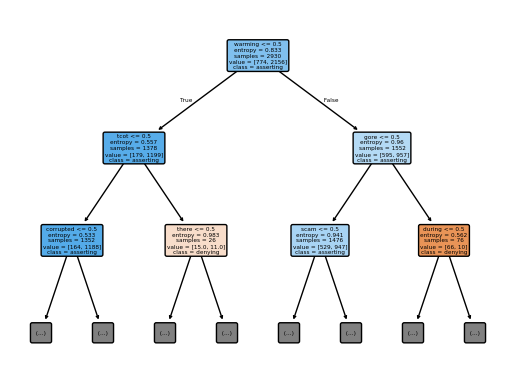

In [7]:
plot_tree(best_classifier,
          max_depth=2, 
          feature_names=vectorizer.get_feature_names_out(),
          class_names=['denying', 'asserting'],
          filled=True,
          rounded=True)
plt.savefig('tree.pdf')

# (d) Compute the information gain

In [8]:
def compute_entropy(labels):
    """
    Parameters:
    - labels (ndarray): Array of labels (0 or 1).
    """
    n = len(labels)
    if n == 0:
        return 0
    
    p_1 = np.sum(labels) / n  # Proportion of positive samples
    p_0 = 1 - p_1             # Proportion of negative samples
    
    entropy = 0     # Handle log(0) case
    if p_1 > 0:
        entropy -= p_1 * np.log2(p_1)
    if p_0 > 0:
        entropy -= p_0 * np.log2(p_0)
    
    return entropy

In [9]:
def compute_information_gain(X, y, feature_index):
    """
    Computes the information gain of a split on a given feature.
    """
    # Total entropy before the split
    total_entropy = compute_entropy(y)
    
    # Split data based on the existence of the keyword (feature_index)
    feature_column = X[:, feature_index]
    
    # Split where the keyword exists (True) and does not exist (False)
    y_true = y[feature_column > 0]   # Tweets where keyword exists
    y_false = y[feature_column == 0] # Tweets where keyword does not exist
    
    # Entropy after the split
    n = len(y)
    n_true = len(y_true)
    n_false = len(y_false)
    
    entropy_true = compute_entropy(y_true)
    entropy_false = compute_entropy(y_false)
    
    conditional_entropy = (n_true / n) * entropy_true + (n_false / n) * entropy_false
    
    information_gain = total_entropy - conditional_entropy
    return information_gain

In [10]:
def print_ig(keyword):
    feature_index = vectorizer.vocabulary_[keyword]
    ig = compute_information_gain(X_train, y_train, feature_index)
    print('Keyword: {0: <8} Information Gain: {1}'.format(keyword, ig))

In [11]:
print_ig('warming')
print_ig('climate')
print_ig('change')
print_ig('global')
print_ig('scam')
print_ig('theory')
print_ig('random')

Keyword: warming  Information Gain: 0.06221614264141173
Keyword: climate  Information Gain: 0.04276582223236469
Keyword: change   Information Gain: 0.04506291595343326
Keyword: global   Information Gain: 0.0571059428982198
Keyword: scam     Information Gain: 0.01586762498217764
Keyword: theory   Information Gain: 0.002097028843104143
Keyword: random   Information Gain: 0.0


# (e) KNN

In [12]:
def evaluate_knn(k):
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)
    
    y_pred_train = clf.predict(X_train)
    accuracy_train = np.sum(y_train == y_pred_train) / len(y_train)
    
    y_pred_val = clf.predict(X_val)
    accuracy_val = np.sum(y_val == y_pred_val) / len(y_val)
    return accuracy_train, accuracy_val, clf

In [13]:
def select_knn_model():
    k_values = np.arange(1, 20)
    train_metrics = dict()
    val_metrics = dict()
    classifiers = dict()
    
    for k in k_values:
        accuracy_train, accuracy_val, clf = evaluate_knn(k)
        train_metrics[k] = accuracy_train
        val_metrics[k] = accuracy_val
        classifiers[k] = clf
        print(f'k: {k}, Validation Accuracy: {accuracy_val}, Train Accuracy: {accuracy_train}')
    return train_metrics, val_metrics, classifiers

knn_metrics_train, knn_metrics_val, knn_classifiers = select_knn_model()

k: 1, Validation Accuracy: 0.7818471337579618, Train Accuracy: 0.9945392491467577
k: 2, Validation Accuracy: 0.7277070063694268, Train Accuracy: 0.9109215017064847
k: 3, Validation Accuracy: 0.7659235668789809, Train Accuracy: 0.8819112627986349
k: 4, Validation Accuracy: 0.7340764331210191, Train Accuracy: 0.847098976109215
k: 5, Validation Accuracy: 0.7754777070063694, Train Accuracy: 0.8580204778156997
k: 6, Validation Accuracy: 0.7563694267515924, Train Accuracy: 0.8505119453924914
k: 7, Validation Accuracy: 0.7659235668789809, Train Accuracy: 0.8348122866894198
k: 8, Validation Accuracy: 0.7563694267515924, Train Accuracy: 0.8440273037542663
k: 9, Validation Accuracy: 0.7802547770700637, Train Accuracy: 0.8225255972696246
k: 10, Validation Accuracy: 0.7722929936305732, Train Accuracy: 0.8255972696245734
k: 11, Validation Accuracy: 0.7834394904458599, Train Accuracy: 0.8156996587030717
k: 12, Validation Accuracy: 0.7898089171974523, Train Accuracy: 0.8170648464163822
k: 13, Validat

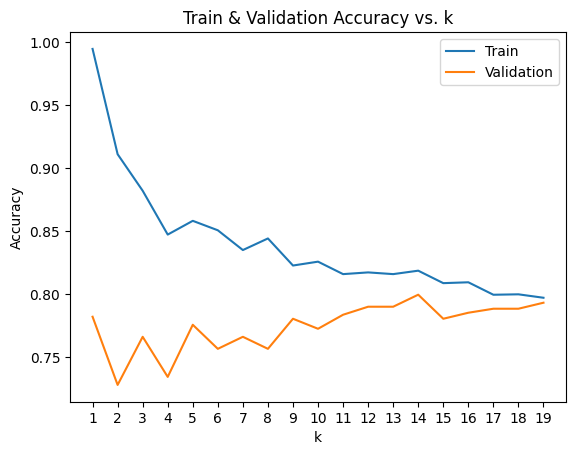

In [14]:
def plot_metrics(train_metrics, val_metrics):
    plt.plot(train_metrics.keys(), train_metrics.values(), label='Train')
    plt.plot(val_metrics.keys(), val_metrics.values(), label='Validation')
    plt.xticks(np.arange(1, 20))
    plt.legend()
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    plt.title('Train & Validation Accuracy vs. k')
    plt.savefig('knn.pdf')
    
plot_metrics(knn_metrics_train, knn_metrics_val)

In [15]:
best_knn_ind = max(knn_metrics_val, key=knn_metrics_val.get)
best_knn_ind, knn_metrics_val[best_knn_ind]

(np.int64(14), np.float64(0.7993630573248408))

In [16]:
best_knn = knn_classifiers[best_knn_ind]
y_pred_test_knn = best_knn.predict(X_test)
test_accuracy_knn = np.sum(y_test == y_pred_test_knn) / len(y_test)
float(test_accuracy_knn)

0.7503974562798092